In [1]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from samples.CLS2IDX import CLS2IDX

# Auxiliary Functions

In [8]:
from baselines.ViT.ViT_LRP import deit_tiny_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained with DeiT
model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = LRP(model)

use_thresholding = False

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

Top 5 classes:
	243 : bull mastiff    		value = 6.742	 prob = 26.6%
	242 : boxer           		value = 5.281	 prob = 6.2%
	282 : tiger cat       		value = 4.821	 prob = 3.9%
	254 : pug, pug-dog    		value = 4.647	 prob = 3.3%
	281 : tabby, tabby cat		value = 4.288	 prob = 2.3%


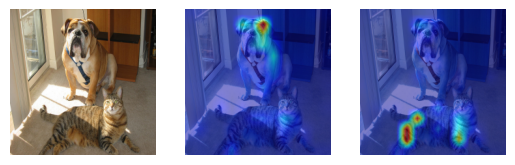

In [9]:
image = Image.open('samples/catdog.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# dog 
# generate visualization for class 243: 'bull mastiff' - the predicted class
dog = generate_visualization(dog_cat_image)

# cat - generate visualization for class 282 : 'tiger cat'
cat = generate_visualization(dog_cat_image, class_index=282)


axs[1].imshow(dog);
axs[1].axis('off');
axs[2].imshow(cat);
axs[2].axis('off');

Top 5 classes:
	243 : bull mastiff    		value = 6.742	 prob = 26.6%
	242 : boxer           		value = 5.281	 prob = 6.2%
	282 : tiger cat       		value = 4.821	 prob = 3.9%
	254 : pug, pug-dog    		value = 4.647	 prob = 3.3%
	281 : tabby, tabby cat		value = 4.288	 prob = 2.3%


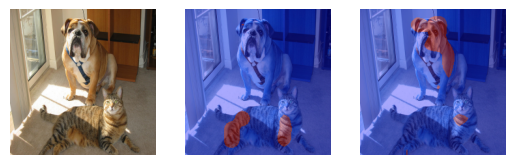

In [10]:
#@title Perform thresholding on the relevance (using Otsu's method)
prev_use_thresholding = use_thresholding
if not use_thresholding:
  use_thresholding = True
image = Image.open('samples/catdog.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(dog_cat_image, class_index=282)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=243)

if not prev_use_thresholding:
  use_thresholding = False

axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

Top 5 classes:
	161 : basset, basset hound         		value = 6.910	 prob = 24.1%
	162 : beagle                       		value = 5.971	 prob = 9.4%
	163 : bloodhound, sleuthhound      		value = 5.411	 prob = 5.4%
	166 : Walker hound, Walker foxhound		value = 4.575	 prob = 2.3%
	88 : macaw                        		value = 4.489	 prob = 2.1%


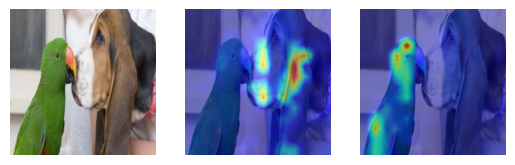

In [11]:
image = Image.open('samples/dogbird.png')
dog_bird_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_bird_image.unsqueeze(0).cuda())
print_top_classes(output)

# basset - the predicted class
basset = generate_visualization(dog_bird_image, class_index=161)

# generate visualization for class 90: 'lorikeet'
parrot = generate_visualization(dog_bird_image, class_index=90)


axs[1].imshow(basset);
axs[1].axis('off');
axs[2].imshow(parrot);
axs[2].axis('off');

Top 5 classes:
	340 : zebra                               		value = 6.059	 prob = 18.7%
	386 : African elephant, Loxodonta africana		value = 5.824	 prob = 14.7%
	101 : tusker                              		value = 4.804	 prob = 5.3%
	385 : Indian elephant, Elephas maximus    		value = 4.583	 prob = 4.3%
	680 : nipple                              		value = 2.285	 prob = 0.4%


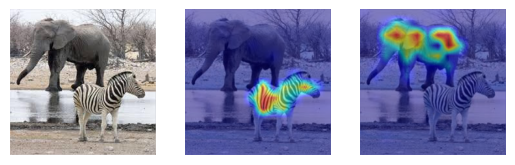

In [12]:
image = Image.open('samples/el2.png')
tusker_zebra_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(tusker_zebra_image.unsqueeze(0).cuda())
print_top_classes(output)

# zebra 
# zebra- the predicted class
zebra = generate_visualization(tusker_zebra_image, class_index=340)

# generate visualization for class 101: 'tusker'
tusker = generate_visualization(tusker_zebra_image, class_index=101)

axs[1].imshow(zebra);
axs[1].axis('off');
axs[2].imshow(tusker);
axs[2].axis('off');

Top 5 classes:
	207 : golden retriever  		value = 6.523	 prob = 35.7%
	208 : Labrador retriever		value = 4.288	 prob = 3.8%
	285 : Egyptian cat      		value = 3.641	 prob = 2.0%
	222 : kuvasz            		value = 3.422	 prob = 1.6%
	281 : tabby, tabby cat  		value = 2.778	 prob = 0.8%


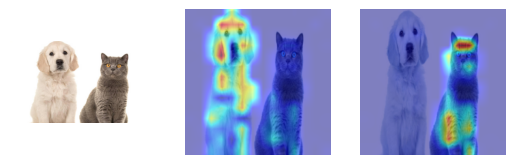

In [7]:
image = Image.open('samples/dogcat2.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# golden retriever - the predicted class
dog = generate_visualization(dog_cat_image)

# generate visualization for class 285: 'Egyptian cat'
cat = generate_visualization(dog_cat_image, class_index=285)


axs[1].imshow(dog);
axs[1].axis('off');
axs[2].imshow(cat);
axs[2].axis('off');